In [31]:
from typing import Callable, Tuple
from finite_distributions.FiniteDistribution import FiniteDistribution
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sinkhorn.SinkhornRunner as SinkhornRunner
import sinkhorn.SinkhornKernels as skern
import visualizer.joint_distribution_visualizer as jdv
import bisect

In [ ]:
def gaussian_prob(mu: float, sigma: float, x: float):
    return np.exp(-(x - mu)**2 / (2 * sigma * sigma))

In [21]:
mu_1 = -0.0
sigma_1 = 1.0

mu_2 = 0.0
sigma_2 = 1.0

In [22]:
nElems = 100
xs = [round(x, 5) for x in np.linspace(-5, 5, nElems)]

In [23]:
s1 = np.sum([gaussian_prob(mu_1, sigma_1, x) for x in xs])
s2 = np.sum([gaussian_prob(mu_2, sigma_2, x) for x in xs])

dist_1 = FiniteDistribution({x: gaussian_prob(mu_1, sigma_1, x) / s1 for x in xs})
dist_2 = FiniteDistribution({x: gaussian_prob(mu_2, sigma_2, x) / s2 for x in xs})

In [24]:
epsilon = 1.0
c = lambda x, y: (x - y)**2

In [25]:
def unregularized_transport_map(x: float) -> float:
    return mu_2 + (x - mu_1) * (sigma_2/sigma_1)

In [26]:
xs2 = np.linspace(-5, 5, nElems)
ys2 = [round(unregularized_transport_map(x), 8) for x in xs2]
new_dict = {(x, y): 0 if np.abs(y - unregularized_transport_map(x)) > 1e-8 else gaussian_prob(mu_1, sigma_1, x) / s1 for x in xs2 for y in ys2 if np.abs(x) <= 5 and np.abs(y) <= 5}
new_dict_sum = np.sum(list(new_dict.values()))
new_dict = {tup: new_dict[tup] / new_dict_sum for tup in new_dict}
optimal_transport = FiniteDistribution(new_dict)

In [27]:
# # p-norm
# ps = [1.01, 1.1, 1.5, 2., 3., 5.]
# sinkhorn_runners = {}
# for p in ps:
#     sinkhorn_runners[p] = skern.get_pnorm_regularized_runner(p, c)
# # entropic
# sinkhorn_runner_entropic = skern.get_entropically_regularized_runner(c)


# epsilon = 1.
# delta = 0.01

# sinkhorns_ran = {}
# for p in ps:
#     (pi_p, f_p, g_p) = sinkhorn_runners[p].run_sinkhorn(dist_1, dist_2, epsilon, delta)
#     sinkhorns_ran[p] = (pi_p, f_p, g_p)
# pi_e, f_e, g_e = sinkhorn_runner_entropic.run_sinkhorn(dist_1, dist_2, epsilon, delta)

In [28]:
# p-norm
p = 2.
sinkhorn_runner_2 = skern.get_pnorm_regularized_runner(p, c)
epsilons = np.linspace(0.05, 1.0, 20) #[0.025, 0.1, 0.5, 1., 2., 3.]

delta = 0.05 # kinda weak requirement... 

sinkhorns_ran_eps = {}
for epsilon in epsilons:
    print(f"Starting epsilon = {epsilon}")
    (pi_p, f_p, g_p) = sinkhorn_runner_2.run_sinkhorn(dist_1, dist_2, epsilon, delta)
    sinkhorns_ran_eps[epsilon] = (pi_p, f_p, g_p)

Starting epsilon = 0.05
Starting epsilon = 0.1
Starting epsilon = 0.15
Starting epsilon = 0.2
Starting epsilon = 0.25
Starting epsilon = 0.3
Starting epsilon = 0.35
Starting epsilon = 0.39999999999999997
Starting epsilon = 0.44999999999999996
Starting epsilon = 0.49999999999999994
Starting epsilon = 0.5499999999999999
Starting epsilon = 0.6
Starting epsilon = 0.65
Starting epsilon = 0.7
Starting epsilon = 0.75
Starting epsilon = 0.7999999999999999
Starting epsilon = 0.85
Starting epsilon = 0.9
Starting epsilon = 0.95
Starting epsilon = 1.0


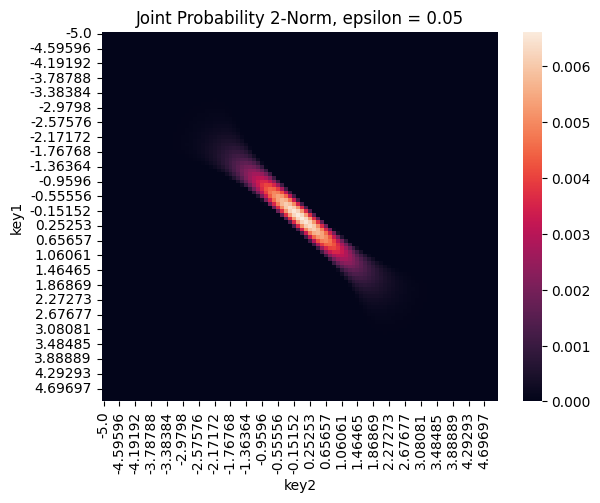

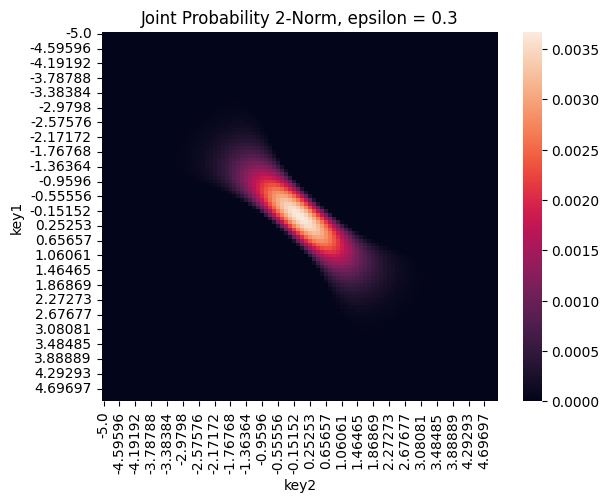

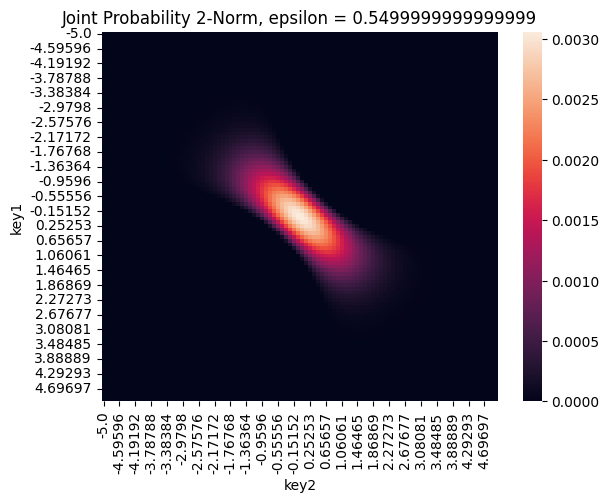

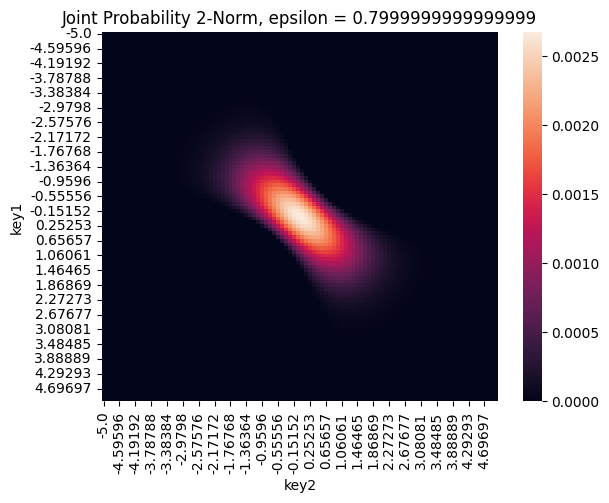

In [45]:
for epsilon in epsilons[::5]:
    pi_p = sinkhorns_ran_eps[epsilon][0]
    jdv.visualize_joint_probability(pi_p, title = f"Joint Probability 2-Norm, epsilon = {epsilon}", annot = False)

In [ ]:
# # plt.figure()
# maxDiameters = []
# minDiameters = []
# for epsilon in epsilons:
#     print(f"Doing eps = {epsilon}")
#     (pi_p, f_p, g_p) = sinkhorns_ran_eps[epsilon]
#     xs = list(f_p.keys()) # sorted(list(f_p.keys()))
#     ys = list(g_p.keys())
#     # conditionals = []
#     maxMins = []
#     for x in xs:
#         totSumProb = 0
#         totSumWeighted = 0
#         maxMin = [np.inf, -np.inf]
#         for y in ys:
#             prob = pi_p.get_probability((x, y))
#             totSumProb += prob
#             totSumWeighted += prob * y
#             if prob > 0:
#                 if y < maxMin[0]:
#                     maxMin[0] = y
#                 if y > maxMin[1]:
#                     maxMin[1] = y
#         # conditionals.append(0 if totSumProb == 0 else totSumWeighted/totSumProb)
#         maxMins.append(maxMin)

#     # plt.plot(xs, [conditionals[i] - xs[i] for i in range(len(xs))], label = f"Epsilon = {epsilon}")
#     maxDiameter = np.max([tup[1] - tup[0] for tup in maxMins if np.abs(tup[0]) != np.inf and np.abs(tup[1]) != np.inf])
#     minDiameter = np.min([tup[1] - tup[0] for tup in maxMins if np.abs(tup[0]) != np.inf and np.abs(tup[1]) != np.inf])
#     maxDiameters.append(maxDiameter)
#     minDiameters.append(minDiameter)

# # plt.title("Residuals against y = x")
# # plt.legend()
# # plt.show()


In [53]:
maxDiameters = []
minDiameters = []
avgDiameters = []

xs = None
ys = None

for epsilon in epsilons:
    print(f"Doing eps = {epsilon}")
    (pi_p, f_p, g_p) = sinkhorns_ran_eps[epsilon]
    if xs is None or ys is None:
        xs = sorted(list(f_p.keys()))
        ys = sorted(list(g_p.keys()))
    maxMins = []
    for x in xs[int(0.35*nElems):int(0.65*nElems)]:
        maxMin = [np.inf, -np.inf]
        expected_y = unregularized_transport_map(x) 
        expected_index = bisect.bisect_left(ys, expected_y) # this is the first index such that $x <= y$


        i = expected_index
        while i < len(ys):
            y = ys[i]
            if pi_p.get_probability((x, y)) < 1e-9:
                break
            maxMin[1] = y
            i += 1

        i = expected_index
        while i >= 0:
            y = ys[i]
            if pi_p.get_probability((x, y)) < 1e-9:
                break
            maxMin[0] = y
            i -= 1 
            
        maxMins.append(maxMin)

    maxDiameter = np.max([tup[1] - tup[0] for tup in maxMins if np.abs(tup[0]) != np.inf and np.abs(tup[1]) != np.inf])
    minDiameter = np.min([tup[1] - tup[0] for tup in maxMins if np.abs(tup[0]) != np.inf and np.abs(tup[1]) != np.inf])
    avg_diameter = np.mean([tup[1] - tup[0] for tup in maxMins if np.abs(tup[0]) != np.inf and np.abs(tup[1]) != np.inf])
    maxDiameters.append(maxDiameter)
    minDiameters.append(minDiameter)
    avgDiameters.append(avg_diameter)



Doing eps = 0.05
Doing eps = 0.1
Doing eps = 0.15
Doing eps = 0.2
Doing eps = 0.25
Doing eps = 0.3
Doing eps = 0.35
Doing eps = 0.39999999999999997
Doing eps = 0.44999999999999996
Doing eps = 0.49999999999999994
Doing eps = 0.5499999999999999
Doing eps = 0.6
Doing eps = 0.65
Doing eps = 0.7
Doing eps = 0.75
Doing eps = 0.7999999999999999
Doing eps = 0.85
Doing eps = 0.9
Doing eps = 0.95
Doing eps = 1.0


In [55]:
logEpsilons = np.log(epsilons)
logEpsilonVariance = np.mean(logEpsilons * logEpsilons) - np.mean(logEpsilons)**2

maxDiametersLog = np.log(np.array(maxDiameters))
logMaxDiametersCovariance = np.mean(maxDiametersLog * logEpsilons) - np.mean(maxDiametersLog)*np.mean(logEpsilons)
betaMax = logMaxDiametersCovariance / logEpsilonVariance

minDiametersLog = np.log(np.array(minDiameters))
logMinDiametersCovariance = np.mean(minDiametersLog * logEpsilons) - np.mean(minDiametersLog)*np.mean(logEpsilons)
betaMin = logMinDiametersCovariance / logEpsilonVariance

avgDiametersLog = np.log(np.array(avgDiameters))
logAvgDiametersCovariance = np.mean(avgDiametersLog * logEpsilons) - np.mean(avgDiametersLog)*np.mean(logEpsilons)
betaAvg = logAvgDiametersCovariance / logEpsilonVariance

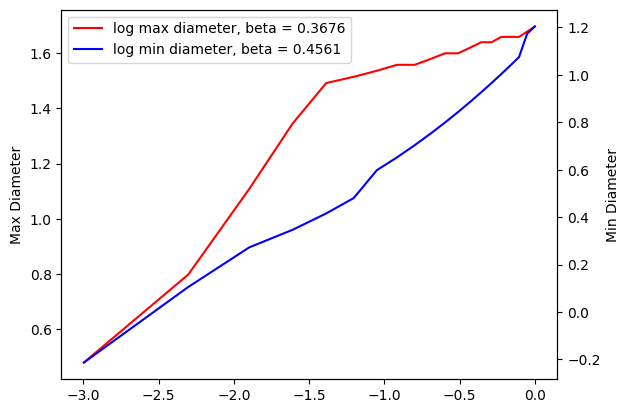

In [56]:
fig, ax1 = plt.subplots() 
ax_twin = ax1.twinx() 

line1 = ax1.plot(logEpsilons, [np.log(maxDiameters[i]) for i in range(len(epsilons))], label = f"log max diameter, beta = {round(betaMax, 4)}", color = 'r')
line2 = ax_twin.plot(logEpsilons, [np.log(minDiameters[i]) for i in range(len(epsilons))], label = f"log min diameter, beta = {round(betaMin, 4)}", color = 'b')

lines = line1 + line2
labels = [line.get_label() for line in lines]

ax1.set_ylabel("Max Diameter")
ax_twin.set_ylabel("Min Diameter")

plt.legend(lines, labels)

plt.show()

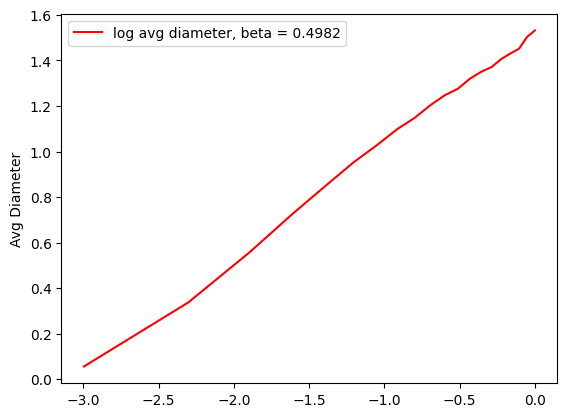

In [57]:
plt.figure()

plt.plot(logEpsilons, [np.log(avgDiameters[i]) for i in range(len(epsilons))], label = f"log avg diameter, beta = {round(betaAvg, 4)}", color = 'r')

plt.ylabel("Avg Diameter")

plt.legend()

plt.show()